In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

# -------------------------- 配置参数 --------------------------
INPUT_PATH = "D:\\workspace\\xiaoyao\\data\\widetable.parquet"  # 原始数据
CONCEPT_INDEX_OUTPUT = "D:\\workspace\\xiaoyao\\data\\concept_index_v2.parquet"  # 概念指数输出路径


# -------------------------- 1. 概念指数核心编制函数 --------------------------
def create_concept_index(input_path, output_path):
    """
    基于concept_name_list（列表格式）编制概念指数
    逻辑：将列表中的每个概念单独计算指数，采用平方根市值加权（同行业指数逻辑）
    """
    print("="*60)
    print("概念指数编制模块启动...")
    print("="*60)
    
    # 1. 读取数据（重点包含concept_name_list字段）
    df = pd.read_parquet(
        input_path,
        engine="pyarrow",
        columns=[
            "date", "stock_code", "close", "pre_close", 
            "circulating_market_cap", "concept_name_list"  # concept_name_list为列表格式
        ]
    )
    
    # 过滤无效数据
    df = df.dropna(subset=["close", "pre_close", "circulating_market_cap", "concept_name_list"])
    df = df[(df["circulating_market_cap"] > 0) & (df["pre_close"] > 0)]
    df["date"] = pd.to_datetime(df["date"])
    
    # 计算个股涨跌幅（%）
    df["pct_change"] = (df["close"] / df["pre_close"] - 1) * 100
    df = df[df["pct_change"].abs() <= 20]  # 过滤极端涨跌幅
    
    # 2. 展开概念列表（将列表中的每个概念拆分为单独行）
    # 例：concept_name_list = ["人工智能", "算力"] → 拆分为两行，分别对应两个概念
    expanded = []
    for _, row in df.iterrows():
        for concept in row["concept_name_list"]:
            expanded.append({
                "date": row["date"],
                "stock_code": row["stock_code"],
                "concept_name": concept,
                "pct_change": row["pct_change"],
                "circulating_market_cap": row["circulating_market_cap"]
            })
    expanded_df = pd.DataFrame(expanded)
    print(f"概念列表展开完成：共{len(expanded_df['concept_name'].unique())}个概念，{len(expanded_df)}条数据")
    
    # 3. 按概念+日期分组计算指数（平方根加权）
    all_concept_index = []
    grouped = expanded_df.groupby(["date", "concept_name"])
    
    for (date, concept), group in grouped:
        n_stocks = len(group)
        if n_stocks < 3:  # 过滤成分股太少的概念（至少3只）
            continue
        
        # 平方根加权（同行业指数逻辑，避免大市值个股过度影响）
        group["sqrt_cap"] = np.sqrt(group["circulating_market_cap"])
        total_sqrt_cap = group["sqrt_cap"].sum()
        group["weight"] = group["sqrt_cap"] / total_sqrt_cap
        
        # 计算概念指数核心指标
        concept_pct = (group["pct_change"] * group["weight"]).sum()  # 加权涨跌幅
        max_weight_ratio = group["weight"].max() * 100  # 最大权重个股占比（监控集中度）
        
        all_concept_index.append({
            "trade_date": date,
            "concept_name": concept,
            "index_pct_change": round(concept_pct, 2),  # 概念指数涨跌幅（%）
            "component_count": n_stocks,  # 成分股数量
            "max_weight_ratio": round(max_weight_ratio, 1),  # 最大权重占比（%）
            "total_market_cap": group["circulating_market_cap"].sum()  # 概念总市值
        })
    
    # 4. 标准化处理（跨概念可比）
    concept_df = pd.DataFrame(all_concept_index)
    
    # 按日期标准化涨跌幅（Z-score），让不同概念的热度可对比
    def normalize_by_date(group):
        mean = group["index_pct_change"].mean()
        std = group["index_pct_change"].std()
        group["std_pct"] = (group["index_pct_change"] - mean) / (std if std != 0 else 1)
        return group
    
    concept_df = concept_df.groupby("trade_date", group_keys=False).apply(normalize_by_date)
    concept_df["std_pct"] = concept_df["std_pct"].round(4)
    
    # 5. 过滤极端权重概念（避免单只股票主导）
    concept_df = concept_df[concept_df["max_weight_ratio"] <= 50]
    
    # 6. 保存结果
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    concept_df.to_parquet(output_path, engine="pyarrow", index=False, compression="snappy")
    
    # 输出统计信息
    print(f"\n✅ 概念指数编制完成！共{concept_df['concept_name'].nunique()}个有效概念")
    print(f"保存路径：{output_path}")
    print(f"日期范围：{concept_df['trade_date'].min().strftime('%Y-%m-%d')}至{concept_df['trade_date'].max().strftime('%Y-%m-%d')}")
    print("="*60)
    
    return concept_df


# -------------------------- 2. 执行概念指数编制 --------------------------
if __name__ == "__main__":
    concept_index_df = create_concept_index(INPUT_PATH, CONCEPT_INDEX_OUTPUT)

概念指数编制模块启动...
概念列表展开完成：共377个概念，8648821条数据


C:\Users\user\AppData\Local\Temp\ipykernel_14904\697821194.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  concept_df = concept_df.groupby("trade_date", group_keys=False).apply(normalize_by_date)



✅ 概念指数编制完成！共370个有效概念
保存路径：D:\workspace\xiaoyao\data\concept_index_v2.parquet
日期范围：2025-01-02至2025-10-30


分析时间范围: 2025-10-20 至 2025-10-30
已计算 9 天的概念TOP10

【2025-10-29 vs 2025-10-30】概念TOP10变动对比
概念名称                 | 前日排名     | 当日排名     | 热度值      | 变动类型
----------------------------------------------------------------------------------------------------
盐湖提锂                 | 8.0      | 1.0      | 3.48     | 上升
航运概念                 | -        | 2.0      | 3.2      | 新晋
钛白粉概念                | -        | 3.0      | 2.8      | 新晋
特钢概念                 | -        | 4.0      | 2.58     | 新晋
稀土永磁                 | 10.0     | 5.0      | 2.34     | 上升
培育钻石                 | -        | 6.0      | 2.64     | 新增
氟化工概念                | -        | 7.0      | 2.2      | 新增
钴                    | 4.0      | 8.0      | 2.24     | 下降
回购增持再贷款              | -        | 9.0      | 2.1      | 新晋
磷化工                  | 9.0      | 10.0     | 2.06     | 下降
BC电池                 | 1.0      | -        | -        | 剔除
海南自贸区                | 2.0      | -        | -        | 剔除
钙钛矿电池                | 3.0      | -        

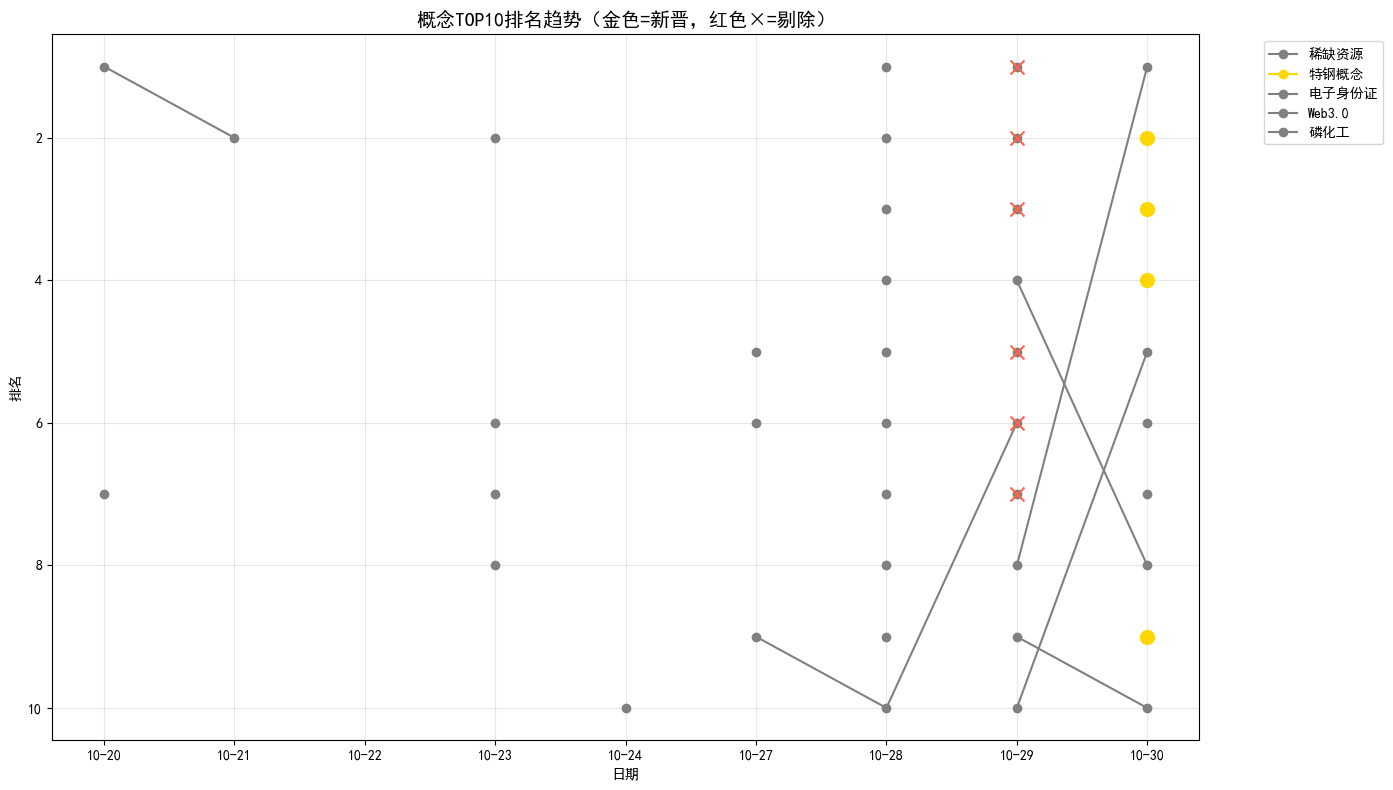

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------- 配置参数 --------------------------
CONCEPT_INDEX_PATH = "D:\\workspace\\xiaoyao\\data\\concept_index_v2.parquet"
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']

# 时间范围（最近10天）
END_DATE = pd.to_datetime(datetime.now().date())
START_DATE = END_DATE - timedelta(days=10)

# 颜色定义
COLOR_NEW = '#32CD32'    # 新增概念
COLOR_REMOVE = '#FF6347' # 剔除概念
COLOR_FIRST = '#FFD700'  # 新晋概念（首次上榜）
COLOR_UP = '#20B2AA'     # 排名上升
COLOR_DOWN = '#FFA500'   # 排名下降


# -------------------------- 1. 概念TOP10计算 --------------------------
def load_and_calculate_concept_top10():
    """计算每日概念TOP10（基于综合得分）"""
    df = pd.read_parquet(CONCEPT_INDEX_PATH)
    df = df[
        (df["trade_date"] >= START_DATE) &
        (df["trade_date"] <= END_DATE)
    ].copy()
    
    # 检查必要字段
    required_cols = ["trade_date", "concept_name", "std_pct", "component_count", "max_weight_ratio"]
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"缺少字段：{missing}")
    
    # 计算每日TOP10（得分逻辑与行业指数一致）
    daily_top10 = {}
    for date in sorted(df["trade_date"].unique()):
        daily_data = df[df["trade_date"] == date].copy()
        
        # 综合得分计算
        std_min, std_max = daily_data["std_pct"].min(), daily_data["std_pct"].max()
        daily_data["heat_score"] = ((daily_data["std_pct"] - std_min)/(std_max - std_min + 1e-8)) * 50
        
        daily_data["count_score"] = np.where(
            (daily_data["component_count"] >= 10) & (daily_data["component_count"] <= 50), 20,
            np.where((daily_data["component_count"] < 5) | (daily_data["component_count"] > 100), 5, 10)
        )
        
        daily_data["diversity_score"] = (1 - daily_data["max_weight_ratio"]/100) * 30
        daily_data["total_score"] = (daily_data["heat_score"] + daily_data["count_score"] + daily_data["diversity_score"]).round(1)
        
        # 取TOP10
        top10 = daily_data.sort_values("total_score", ascending=False).head(10)[
            ["concept_name", "std_pct", "total_score"]
        ].reset_index(drop=True)
        top10["排名"] = range(1, 11)
        daily_top10[date] = top10
    
    return daily_top10


# -------------------------- 2. 概念变动对比表格 --------------------------
def generate_concept_comparison(daily_top10):
    """生成概念TOP10变动对比表格（彩色输出）"""
    all_dates = sorted(daily_top10.keys())
    if len(all_dates) < 2:
        return None, None, None
    
    prev_date = all_dates[-2]
    curr_date = all_dates[-1]
    prev_df = daily_top10[prev_date].set_index("concept_name")
    curr_df = daily_top10[curr_date].set_index("concept_name")
    
    # 用列表作为索引（避免set类型错误）
    all_concepts = list(set(prev_df.index.tolist() + curr_df.index.tolist()))
    comparison = pd.DataFrame(index=all_concepts)
    
    # 填充数据
    comparison["前日排名"] = prev_df["排名"].reindex(comparison.index)
    comparison["当日排名"] = curr_df["排名"].reindex(comparison.index)
    comparison["热度值"] = curr_df["std_pct"].reindex(comparison.index).round(2)
    
    # 标记变动类型
    def mark_change(row):
        if pd.isna(row["前日排名"]) and not pd.isna(row["当日排名"]):
            # 检查是否为首次上榜
            is_first = True
            for d in daily_top10:
                if d == curr_date:
                    continue
                if row.name in daily_top10[d]["concept_name"].values:
                    is_first = False
                    break
            return "新晋" if is_first else "新增"
        elif not pd.isna(row["前日排名"]) and pd.isna(row["当日排名"]):
            return "剔除"
        elif not pd.isna(row["前日排名"]) and not pd.isna(row["当日排名"]):
            return "上升" if row["当日排名"] < row["前日排名"] else "下降" if row["当日排名"] > row["前日排名"] else "不变"
        else:
            return "-"
    
    comparison["变动类型"] = comparison.apply(mark_change, axis=1)
    comparison = comparison.sort_values(by=["当日排名", "前日排名"], na_position="last").fillna("-")
    return comparison, prev_date, curr_date


# -------------------------- 3. 概念变动可视化 --------------------------
def plot_concept_trend(daily_top10):
    """绘制概念排名趋势图"""
    all_dates = sorted(daily_top10.keys())
    if len(all_dates) < 3:
        print("数据不足3天，无法绘制趋势图")
        return
    
    # 提取排名数据
    rank_data = {}
    for date in all_dates:
        for _, row in daily_top10[date].iterrows():
            concept = row["concept_name"]
            if concept not in rank_data:
                rank_data[concept] = {d: np.nan for d in all_dates}
            rank_data[concept][date] = row["排名"]
    
    rank_df = pd.DataFrame(rank_data).T
    recent_concepts = set()
    for d in all_dates[-3:]:
        recent_concepts.update(daily_top10[d]["concept_name"].head(15))
    rank_df = rank_df.loc[list(recent_concepts)]
    
    # 绘图
    plt.figure(figsize=(14, 8))
    date_labels = [d.strftime("%m-%d") for d in all_dates]
    
    for concept in rank_df.index:
        ranks = rank_df.loc[concept].values
        first_idx = np.where(~pd.isna(ranks))[0][0] if any(~pd.isna(ranks)) else -1
        
        plt.plot(date_labels, ranks, marker='o', 
                 color=COLOR_FIRST if first_idx == len(all_dates)-1 else 'gray',
                 label=concept if concept in list(rank_df.index)[:5] else "")
        
        # 标记新晋和剔除
        if first_idx == len(all_dates)-1:
            plt.scatter(date_labels[-1], ranks[-1], color=COLOR_FIRST, s=100, zorder=5)
        if len(ranks)>=2 and not pd.isna(ranks[-2]) and pd.isna(ranks[-1]):
            plt.scatter(date_labels[-2], ranks[-2], color=COLOR_REMOVE, s=100, marker='x', zorder=5)
    
    plt.gca().invert_yaxis()  # 排名1在最上方
    plt.title("概念TOP10排名趋势（金色=新晋，红色×=剔除）", fontsize=14)
    plt.xlabel("日期")
    plt.ylabel("排名")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------------- 4. 彩色打印概念变动表格 --------------------------
def print_colored_concept_table(comparison, prev_date, curr_date):
    if comparison is None:
        return
    
    print(f"\n" + "="*100)
    print(f"【{prev_date.strftime('%Y-%m-%d')} vs {curr_date.strftime('%Y-%m-%d')}】概念TOP10变动对比")
    print("="*100)
    print(f"{'概念名称':<20} | {'前日排名':<8} | {'当日排名':<8} | {'热度值':<8} | 变动类型")
    print("-"*100)
    
    for concept, row in comparison.iterrows():
        color_map = {
            "新晋": "\033[93m", "新增": "\033[92m", 
            "剔除": "\033[91m", "上升": "\033[96m", 
            "下降": "\033[91m"
        }
        color_code = color_map.get(row["变动类型"], "\033[0m")
        print(f"{color_code}{concept:<20} | {row['前日排名']:<8} | {row['当日排名']:<8} | {row['热度值']:<8} | {row['变动类型']}\033[0m")


# -------------------------- 5. 主函数 --------------------------
def main():
    print(f"分析时间范围: {START_DATE.strftime('%Y-%m-%d')} 至 {END_DATE.strftime('%Y-%m-%d')}")
    
    try:
        daily_top10 = load_and_calculate_concept_top10()
        print(f"已计算 {len(daily_top10)} 天的概念TOP10")
        
        comparison, prev_date, curr_date = generate_concept_comparison(daily_top10)
        print_colored_concept_table(comparison, prev_date, curr_date)
        
        plot_concept_trend(daily_top10)
    
    except Exception as e:
        print(f"执行出错: {str(e)}")


if __name__ == "__main__":
    main()